In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
%matplotlib inline

C:\Python36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Python36\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 서울 & 경기권 대중교통의 분실물 현황 및 분실물 처리 결과 예측

### 1. 본 분석은 2017년 8월 2일 [서울 열린 데이터 광장]에 등록된 자료를 기반으로 함
####            (http://data.seoul.go.kr/openinf/sheetview.jsp?infId=OA-124&tMenu=11)

### 2. 분석 목표
* 서울 및 경기권 대중교통(지하철, 택시, 버스)에서 발생한 승객의 분실물의 현황을 파악하고, 이러한 분실물이 어떻게 처리되는지에 대한 결과를 예측

### 3. 분석 도구
* Python : 데이터 전처리 및 현황 파악, 분실물 처리 결과 모델 구축 및 예측
* excel : 데이터 전처리

### 3. 최초 데이터 현황
##### 1) 기간 : 2007년 11월 2일 부터 2017년 8월 2일 까지
##### 2) 개수 : 총 163,950개
##### 3) 데이터 구성
* 서울 및 경기권의 택시와 버스에서 나온 분실물 데이터
* 서울 및 경기권 지하철 역 분실물 데이터
* 전국 기차역 및 일부 지역 지하철 역 분실물 데이터

##### 4) 데이터  설명
* 분실물 ID : 해당 데이터 고유 번호
* 습득물품명	: 습득 물품 이름 또는 상태 (같은 종류여도 작성자에 따라 표기법, 맞춤법 등이 상이할 수 있음)
* 원문링크주소(지하철) : 지하철 또는 기차에서 나온 분실물에 대한 안내 페이지 링크
* 습득물분류(지하철) : 샘플데이터를 나타내기 위해 만들어진 열, 분석에서는 필요 없음
* 습득일자 : 분실물이 발생한 날짜 혹은 분실물 센터로 접수된 날짜
* 수령가능장소 : 분실물을 등록 혹은 현황을 업데이트 한 시점에서의 분실물을 수령 가능한 장소 (지하철역, 기차역, 회사 내 분실센터, 경찰서, 우체국 등)
* 수령가능장소연락처	: 상기 수령가능장소의 연락처
* 습득물분류	: 습득물에 종류에 따른 분류, 최초 분류는 [가방, 기타, 베낭, 샘플데이터, 서류봉투, 쇼핑백, 옷, 지갑, 책, 파일, 핸드폰]으로 구성
* 습득위치_회사명 : 분실물을 접수/습득한 택시 또는 버스 회사 명, 택시 차량번호 등
* 습득위치(지하철)	: 분실물을 접수/습득한 지하철 또는 기차 정보 또는 역사 내/주변 습득 장소 정보
* 습득물품_상세 : 분실물을 접수/습득한 시점에서의 분실물에 대한 상세 내용
* 분실물상태	: 분실물의 현재 상태, [보관, 경찰서 이관, 우체국 이관] 총 3개로 구성, 본 분석에서 최종 예측 결과로 사용 예정
* 습득물품코드 : 분실물의 접수/습득 시점에서의 교통수단, [b1, b2, s1, s3, t1, t2]로 구성, b = 버스, s = 지하철/기차, t = 택시를 나타냄
* 이미지 URL : 분실물 사진 링크 여부


In [2]:
# Read the Raw_data

Raw_data = pd.read_csv('Raw_data.csv', encoding='CP949')

C:\Python36\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Raw_data.shape

(163950, 14)

In [4]:
Raw_data.head(10)

,분실물 ID,습득물품명,원문링크주소(지하철),습득물분류(지하철),습득일자,수령가능장소,수령가능장소연락처,습득물분류,습득위치_회사명,습득위치(지하철),습득물품_상세,분실물상태,습득물품코드,이미지 URL
0,1228831,NaN,http://lost.korail.com/view/view.asp?f_num=1ed...,NaN,NaN,NaN,NaN,기타,NaN,NaN,NaN,보관,s3,aaa.jpg
1,1360729,NaN,http://lost.korail.com/view/view.asp?f_num=88b...,NaN,NaN,NaN,NaN,기타,NaN,NaN,NaN,보관,s3,aaa.jpg
2,1364084,NaN,http://lost.korail.com/view/view.asp?f_num=7af...,NaN,NaN,NaN,NaN,기타,NaN,NaN,NaN,보관,s3,aaa.jpg
3,1224264,NaN,http://lost.korail.com/view/view.asp?f_num=70f...,NaN,NaN,NaN,NaN,기타,NaN,NaN,NaN,보관,s3,aaa.jpg
4,61697746,갤럭시 노트4(비밀번호),NaN,NaN,2017-08-02,회사내 분실센터,010-3119-1596,핸드폰,삼익택시,NaN,저희 삼익택시에서는 2017년 08월 02일 핸드폰을(를) 습득/보관 하(였습니다....,보관,t1,http://115.84.165.106/upload/20170802111651.JPG
5,61697745,신분증(전연선),NaN,NaN,2017-08-02,회사내 분실센터,02-902-5691,기타,경일운수,NaN,저희 경일운수에서는 2017년 08월 02일 기타을(를) 습득/보관 하(였습니다.)...,보관,t1,NaN
6,61697714,카드지갑(검정),NaN,NaN,2017-08-01,회사내 분실센터,02-2684-6060,지갑,안전한택시,NaN,저희 안전한택시에서는 2017년 08월 01일 지갑을(를) 습득/보관 하(였습니다....,보관,t1,http://115.84.165.106/upload/20170801100327.jpg
7,61697715,핸드폰,NaN,NaN,2017-08-01,회사내 분실센터,02-2663-9950,핸드폰,효신교통,NaN,저희 효신교통에서는 2017년 08월 01일 핸드폰을(를) 습득/보관 하(였습니다....,보관,t1,http://115.84.165.106/upload/20170801112429.jpg
8,61697724,스마트키(모비스),NaN,NaN,2017-08-01,회사내 분실센터,02-887-5188,기타,동서울택시,NaN,저희 동서울택시에서는 2017년 08월 01일 기타을(를) 습득/보관 하(였습니다....,보관,t1,http://115.84.165.106/upload/20170802092958.jpg
9,61697716,지갑,NaN,NaN,2017-07-31,회사내 분실센터,02-902-6651,지갑,전진교통,NaN,저희 전진교통에서는 2017년 07월 31일 지갑을(를) 습득/보관 하(였습니다.)...,보관,t1,http://115.84.165.106/upload/20170801113047.jpg


In [5]:
Raw_data.tail(3)

,분실물 ID,습득물품명,원문링크주소(지하철),습득물분류(지하철),습득일자,수령가능장소,수령가능장소연락처,습득물분류,습득위치_회사명,습득위치(지하철),습득물품_상세,분실물상태,습득물품코드,이미지 URL
163947,10280743,"가죽가방,통장(강문형)",NaN,NaN,2007-12-02,회사내 분실센터,02-2662-2859,가방,김포교통,NaN,"저희 김포교통에서는 2007년 12월 02일 가방(가죽가방,통장(강문형))을(를) ...",우체국이관,b1,NaN
163948,587101,010-2085-****,NaN,NaN,2007-11-03,회사내 분실센터,011-324-4044,핸드폰,진영운수,NaN,저희 진영운수에서는 2007년 11월 03일 핸드폰을(를) 습득/보관 하(였습니다....,보관,t1,NaN
163949,13014,지갑(박지현),NaN,NaN,2007-11-02,우체국,02-2662-2859,지갑,김포교통,NaN,저희 김포교통에서는 2007년 11월 02일 지갑을(를) 습득/보관 하(였습니다.)...,우체국이관,b1,NaN


In [6]:
HP_data = Raw_data[Raw_data['습득물분류'] == '핸드폰']
HP_data_but_other = HP_data[HP_data['습득물품명'] == '지갑,노트']
HP_data_but_other

,분실물 ID,습득물품명,원문링크주소(지하철),습득물분류(지하철),습득일자,수령가능장소,수령가능장소연락처,습득물분류,습득위치_회사명,습득위치(지하철),습득물품_상세,분실물상태,습득물품코드,이미지 URL
106622,1253531,"지갑,노트",http://lost.korail.com/view/view.asp?f_num=ff7...,NaN,2017-01-05,용산역,02-749-3583,핸드폰,NaN,열차 -기타 (2047열차 ),"지갑과 노트 (곽** 신용카드, 현금없음)",보관,s3,aaa.jpg
106737,1253819,"지갑,노트",http://lost.korail.com/view/view.asp?f_num=5f1...,NaN,2017-01-05,용산역,02-749-3583,핸드폰,NaN,열차 -기타 (2047열차 ),"지갑과 노트 (곽** 신용카드, 현금없음)",보관,s3,aaa.jpg
106828,1253763,"지갑,노트",http://lost.korail.com/view/view.asp?f_num=09a...,NaN,2017-01-05,용산역,02-749-3583,핸드폰,NaN,열차 -기타 (2047열차 ),"지갑과 노트 (곽** 신용카드, 현금없음)",보관,s3,aaa.jpg
107147,1254123,"지갑,노트",http://lost.korail.com/view/view.asp?f_num=71e...,NaN,2017-01-05,용산역,02-749-3583,핸드폰,NaN,열차 -기타 (2047열차 ),"지갑과 노트 (곽** 신용카드, 현금없음)",보관,s3,aaa.jpg
107170,1253593,"지갑,노트",http://lost.korail.com/view/view.asp?f_num=30c...,NaN,2017-01-05,용산역,02-749-3583,핸드폰,NaN,열차 -기타 (2047열차 ),"지갑과 노트 (곽** 신용카드, 현금없음)",보관,s3,aaa.jpg
107309,1253932,"지갑,노트",http://lost.korail.com/view/view.asp?f_num=fe4...,NaN,2017-01-05,용산역,02-749-3583,핸드폰,NaN,열차 -기타 (2047열차 ),"지갑과 노트 (곽** 신용카드, 현금없음)",보관,s3,aaa.jpg
107457,1253875,"지갑,노트",http://lost.korail.com/view/view.asp?f_num=26f...,NaN,2017-01-05,용산역,02-749-3583,핸드폰,NaN,열차 -기타 (2047열차 ),"지갑과 노트 (곽** 신용카드, 현금없음)",보관,s3,aaa.jpg
107536,1254054,"지갑,노트",http://lost.korail.com/view/view.asp?f_num=d58...,NaN,2017-01-05,용산역,02-749-3583,핸드폰,NaN,열차 -기타 (2047열차 ),"지갑과 노트 (곽** 신용카드, 현금없음)",보관,s3,aaa.jpg
107634,1253994,"지갑,노트",http://lost.korail.com/view/view.asp?f_num=925...,NaN,2017-01-05,용산역,02-749-3583,핸드폰,NaN,열차 -기타 (2047열차 ),"지갑과 노트 (곽** 신용카드, 현금없음)",보관,s3,aaa.jpg
107795,1253707,"지갑,노트",http://lost.korail.com/view/view.asp?f_num=373...,NaN,2017-01-05,용산역,02-749-3583,핸드폰,NaN,열차 -기타 (2047열차 ),"지갑과 노트 (곽** 신용카드, 현금없음)",보관,s3,aaa.jpg


### Raw_data 분포 파악 (with pandas and excel)
#### 1. 전체 데이터 행렬은 (163950, 14)
* 그러나 위의 데이터를 보면, '핸드폰'으로 분류되어 있으나, '지갑,노트'로 입력이 되어있는 데이터가 있으며, 이러한 데이터가 중복되어 나타나는 것을 볼 수 있음
* 이러한 중복에 대한 정리가 필요함
* 또한 실제 습득물과 습득물 분류가 상이할 경우 이에 대한 조정 역시 필요함

#### 2. 서울시 제공 데이터지만, 전국의 기차역 및 서울&경기권 외 지역의 지하철 역에 대한 분실물 데이터가 포함되어 있음
* 데이터 제공 기관의 성격과, 본 분석의 목적에 맞게 기차역 및 서울 & 경기권 외 지역의 지하철 역에 대한 데이터는 제외할 필요가 있음

#### 3. 모든 데이터는 Categorical Data
* 대부분의 데이터가 한글로 입력되어 있으며, 입력 스타일이 상이하여 오탈자, 표기법 등 데이터의 상태가 일관적이지 않음
* 이를 처리하기 위해서는 python의 pandas 보다는 excel로 모든 데이터를 직접 확인하며 수정해 줄 필요가 있음

### 데이터 전처리 with excel - step 1

#### 1. 중복 데이터 제거
* 데이터를 보면 중복 내용이 다수 분포
* 이를 해결하기 위하여 '습득물품명'과 '습득일자', '수령가능장소'를 기준으로 하여 excel의 [중복된 항목 제거] 기능을 이용해 중복 제거
* 이 외에 샘플데이터 제거

#### 2. 습득 위치에 대한 항목이 2개 - '습득위치_회사명' & '습득위치(지하철)'
* 같은 내용에 대해 두개의 열로 데이터가 구성되어 있으며, 두개의 열은 겹치지 않음
* 위 두개 열을 통합하여 정리할 필요가 있음
* '습득위치_회사명' 열에는 회사명 또는 차량번호만 존재함
    - 서울시에 등록되어 있는 택시회사와 버스회사 리스트와 매칭시켜 택시와 버스를 정확하게 구분
    - 서울시에 등록되어 있지 않은 경우, '수령가능장소연락처'의 번호 및 회사명을 검색하여 확인
    - 차량번호의 경우 택시로 구분
* '습득위치(지하철)' 열은 지하철로 통일
* 위의 정리 사항을 '습득위치_new'라는 열을 새로 생성하여 통합
* '습득물품코드' 열과 매칭시켜서 정확하게 분류되었는지 확인

#### 3. 수령가능장소
* 해당 열에는 기차역, 지하철역, 회사내 분실센터, 경찰서, 우체국 등으로 데이터가 분류되어 있음
* 회사내 분실센터 : 택시 & 버스에 해당 -> 택시회사_분실센터, 버스회사_분실센터
* 경찰서, 우체국의 경우 전처리 할 필요 없음
* 따라서 기차역과 지하철역에 대해서만 전처리를 해주면 됨
    - 기차역 : 분석목표에 맞지 않음, '수령가능장소' 열 내 기차역 명이 있는 열은 분석대상에서 제외
    - 지하철역 : 분석대상에 해당 -> 지하철역_분실센터
    - 기차역이면서 지하철역인 경우 : 지하철역으로 간주
* '수령가능장소_new'라는 열을 새로 생성하여 통합

### 데이터 전처리 with excel - step 2

#### 1. '습득물품명'에 따라 '습득물분류'가 가능한가?

##### 1) '습득물품명'의 내용과 '습득물분류'의 구분이 매칭이 되지 않는 경우가 존재 (ex : '지갑,노트' - '핸드폰')
* '습득물품명'에 따라서 '습득물분류' 구분에 맞게 수정
* 여러개일 경우 분석가의 판단에 따라 중요도로 구분하여 수정 (ex : '지갑,노트' - '지갑')

##### 2) '습득물분류'의 구분이  분실물을 충실히 구분하여 담아낼 수 있는가?
* '습득물분류'의 '기타' 항목이 66,285로 가장 많음(중복 제거 전 기준) -> '습득물분류'의 신뢰성 의심
* '가방'과 '베낭'이 구분되어 있음 -> 통합 필요성
* 즉, 전체 데이터를 다시 확인하면서 '습득물분류' 열의 구분을 재생산해야 할 필요가 있음

##### 3) '습득물품명'과 '습득물품_상세' 내용은 연관성이 '습득물분류' 구분과 매칭이 되는지 확인해야 함
* 데이터를 보며 '습득물품명', '습득물품_상세'의 내용에 따라 '습득물분류' 구분
* '습득물분류' 구분이 불 충분할 경우, 새로운 구분을 생성 (ex : 우산, 신발, 액세서리, 전자기기, 신분증, 카드 등)
* '습득물품_상세' 에 여러 물품이 포함되어 있다면 분석가의 판단에 따라 중요도 또는 대표물품을 정하여 그에 따라 구분


#### 2. 분석을 위하여 추가적으로 필요한 변수는 없는가?

##### 1) 현재 분석 가능한 변수 확인
* 최초 14개 열 + '수령가능장소_new' + '습득위치_new', 총 16개 열
* 두 개의 새로운 열이 생성되면서 기존의 '수령가능장소', '습득위치_회사명', '습득위치(지하철)' 항목은 분석에 사용하지 않음
* '분실물 ID'는 단순 구분용이기 때문에 분석에 불필요
* '원문링크주소(지하철)'은 '습득위치_new' 열 중 '지하철' 구분에 모두 해당되는 내용이기 때문에 제외(NaN값이 없음)
* '습득물품코드'는 '습득위치_new'와 분류체계가 동일하기 때문에 분석에서 제외
* 총 16개 중 상기 언급된 '수령가능장소', '습득위치_회사명', '습득위치(지하철)', '분실물 ID', '원문링크주소(지하철)', '습득물품코드' 를 제외한 10개를 분석에 사용할 수 있음

##### 2) 새로운 변수 생성 가능성
* 현재 모든 데이터는 Categorical Data이며, 이를 분석에 활용 가능하도록 숫자 변수로 인코딩 혹은 더미화가 필요함
* 이 외에도 분실물이 가지는 추가적인 의미에 대해여 고려할 필요가 있음
* 분실물의 경우 소유자의 신원확인이 가능한 물품이 있음(카드, 신분증, 명함, 핸드폰 등)
    - 신원확인 가능 여부에 대해 '습득물품명'과 '습득물품_상세' 변수를 확인하여 새로운 변수에 대입 -> '신원확인여부'
* 또한 분실물의 소유자(신용카드류의 경우 카드 회사)와 연락이 닿는 경우, 소유자에게 반환이 용이할 수 있음
    - 소유자와의 연락 여부에 대해 '습득물품명'과 '습득물품_상세' 변수를 확인하여 새로운 변수에 대입 -> '소유자연락여부'
* 더미화로 새로운 변수로 변환 가능성 고찰
    - 새롭게 생성한 '신원확인여부', '소유자연락여부' : 해당되면 1, 해당없으면 0
    - '이미지 URL' : 있으면 1, 없으면 0
    - '습득물품_상세' : 상세 설명이 있으면 1, 없으면 0 (단, '습득물품명'과 완전히 동일하게 기입이 되어 있거나, 단순히 '습득물분류'에 대한 설명만 있는 경우 0으로 처리)
* 분석을 위해 텍스트 변수를 숫자로 인코딩
    - 대상 변수 : '수령가능장소_new', '습득물분류', '습득위치_new', '분실물상태'
    
##### 3) '습득일자'의 활용 방향
* '습득일자'는 연도-월-일 의 순으로 구성되어 있으며, 이를 분석에 활용하기 위해서는 각각 '연도', '월', '일'의 3개 변수로 분리하여야 함
* 그러나 이렇게 분리하고 난 뒤 3개의 변수를 모두 사용하여야 하는지에 대해 고려해야 함
    - '연도'의 경우, 분실물의 버전(폴더폰 -> 스마트폰) 상의 차이는 있으나, 본질적으로 '핸드폰'을 의미한다는 점에서는 차이가 없음
    - 따라서 '연도'의 경우 
    - '월'의 경우, 계절성을 띄고 있으며, 매 해 반복되기 때문에 연도에 영향을 받지 않고 월에 따른 분실물의 특징을 알 수 있음
    - '일'의 경우, '1일'에 발생한 분실물과 '21'일에 발생한 분실물에 근본적인 차이가 없음
    - 따라서 '연도'와 '일'은 분석에 사용 시 단순 숫자로서의 역할만 할 가능성이 크며, 과적합의 가능성을 높일 수 있음
    - 향후 분석에서는 '월'만 사용하는 것이 바람직 할 것으로 판단됨

# excel 전처리 후 분석을 위한 Data 생성 - lost_data.csv

In [7]:
# Read the dataset
data = pd.read_csv('lost_data.csv',  encoding='CP949')

C:\Python36\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (4,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
data.tail()

,분실물 ID,습득물품명,신원확인여부,소유자연락여부,원문링크주소(지하철),습득일자,수령가능장소,수령가능장소_new,수령가능장소연락처,습득물분류,습득위치_회사명,습득위치_new,습득위치(지하철),습득물품_상세,분실물상태,습득물품코드,이미지 URL
43039,3860262,스카이.흰색,NaN,NaN,NaN,2007-12-17,우체국,우체국,02-577-5231,핸드폰,서원택시,택시,NaN,NaN,우체국이관,t1,NaN
43040,381169,지갑(윤경식씨),1.0,NaN,NaN,2007-12-05,회사내 분실센터,버스회사_분실센터,02-756-0670,지갑,남성교통,버스,NaN,NaN,보관,b1,NaN
43041,10280743,"가죽가방,통장(강문형)",1.0,NaN,NaN,2007-12-02,회사내 분실센터,버스회사_분실센터,02-2662-2859,가방,김포교통,버스,NaN,NaN,우체국이관,b1,NaN
43042,587101,010-2085-****,1.0,NaN,NaN,2007-11-03,회사내 분실센터,택시회사_분실센터,011-324-4044,핸드폰,진영운수,택시,NaN,NaN,보관,t1,NaN
43043,13014,지갑(박지현),1.0,NaN,NaN,2007-11-02,우체국,우체국,02-2662-2859,지갑,김포교통,버스,NaN,NaN,우체국이관,b1,NaN


### 불필요한 변수 정리

In [9]:
lost_data = data.drop(['수령가능장소', '습득위치_회사명', '습득위치(지하철)', '분실물 ID', '원문링크주소(지하철)', '습득물품코드'], axis=1)
lost_data.tail()

,습득물품명,신원확인여부,소유자연락여부,습득일자,수령가능장소_new,수령가능장소연락처,습득물분류,습득위치_new,습득물품_상세,분실물상태,이미지 URL
43039,스카이.흰색,NaN,NaN,2007-12-17,우체국,02-577-5231,핸드폰,택시,NaN,우체국이관,NaN
43040,지갑(윤경식씨),1.0,NaN,2007-12-05,버스회사_분실센터,02-756-0670,지갑,버스,NaN,보관,NaN
43041,"가죽가방,통장(강문형)",1.0,NaN,2007-12-02,버스회사_분실센터,02-2662-2859,가방,버스,NaN,우체국이관,NaN
43042,010-2085-****,1.0,NaN,2007-11-03,택시회사_분실센터,011-324-4044,핸드폰,택시,NaN,보관,NaN
43043,지갑(박지현),1.0,NaN,2007-11-02,우체국,02-2662-2859,지갑,버스,NaN,우체국이관,NaN


## Python을 활용한 데이터 분포 파악

In [10]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

* 분실물 상태

    - '보관'이 3만개 이상으로 가장 많으며, '경찰서이관'은 5천개 이상, '우체국이관'은 5천개 미만으로 나타남

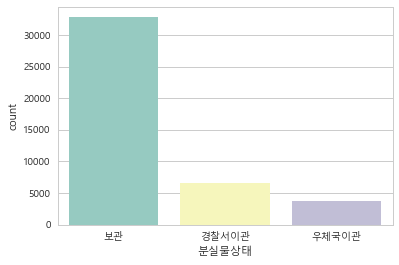

In [11]:
sns.countplot(lost_data.분실물상태, palette='Set3')

* 수령가능장소_new

    - '버스회사 분실센터', '지하철역 분실센터', '택시회사 분실센터', '경찰서', '우체국' 의 순으로 나타남

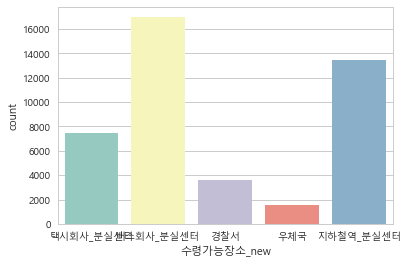

In [12]:
sns.countplot(lost_data.수령가능장소_new, palette='Set3')

* 습득물 분류

    - '핸드폰'이 가장 많고, '지갑', '가방', '의류', '쇼핑백', '기타' 등의 순으로 나타남
    - '서류봉투', '금융관련'(현금, 통장 등) 항목이 적게 나타남

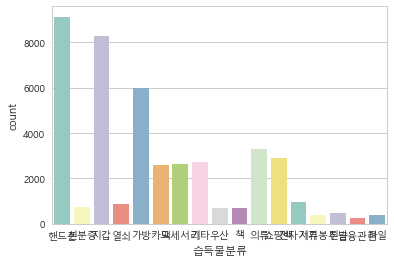

In [13]:
sns.countplot(lost_data.습득물분류, palette='Set3')

* 습득위치_new

    - '버스', '지하철', '택시' 순으로 나타남
    - '수령가능장소_new'와 비슷한 분포를 보임

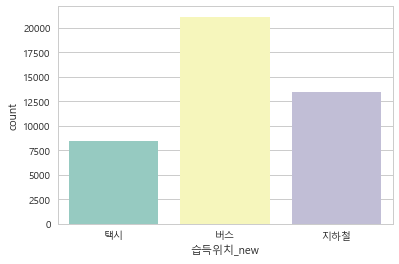

In [14]:
sns.countplot(lost_data.습득위치_new, palette='Set3')

* '분실물상태'와 '수령가능장소_new'와의 관계
    - '분실물상태'='보관'으로 분류되어 있는 경우, 모두 각 교통수단 별 분실센터에 분실물이 있는 것으로 나타남
    - 그러나 '경찰서이관'과 '우체국이관'의 경우, '경찰서' 또는 '우체국'으로 분류되어 있음과 동시에 개별 분실센터에도 분실물이 있는 것으로 나타남
    - 데이터가 작성된 시점에 따른 차이를 고려한다 하더라도, '수령가능장소_new' 변수를 향후 분석에서 사용해야 할 지에 대해 고민할 필요가 있음

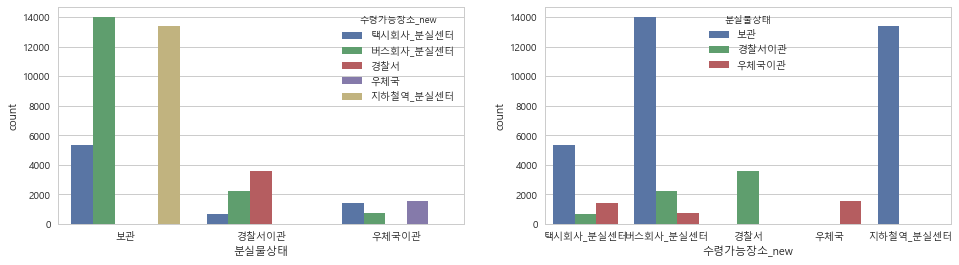

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=lost_data, x='분실물상태',hue='수령가능장소_new', ax=ax1)
sns.countplot(data=lost_data, x='수령가능장소_new',hue='분실물상태', ax=ax2)

* '분실물상태'와 '습득위치_new'와의 관계
    - '지하철'의 경우, '분실물상태'가 모두 '보관'으로 나타남
    - '택시'와 버스' 모두 '보관'으로 분류되어 있는게 가장 많았음
    - '버스'는 '경찰서이관', '택시'는 '우체국이관'이 각각 2순위로 나타남
    - '지하철' = '보관' 이라는 등식이 성립하기 때문에, 분석 결과에 과적합 영향을 줄 것이 예상됨

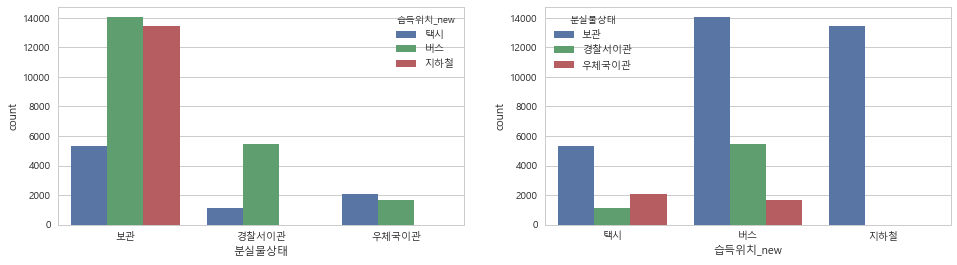

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=lost_data, x='분실물상태',hue='습득위치_new', ax=ax1)
sns.countplot(data=lost_data, x='습득위치_new',hue='분실물상태', ax=ax2)

* '습득위치_new'와 '습득물분류' 와의 관계
    - 전반적으로, 대부분의 '습득물분류' 구분에서 '버스'에서 발견된 분실물이 많은 것으로 나타남
    - 그러나 '열쇠', '가방', '쇼핑백', '전자기기', '서류봉투' 등은 '택시' 혹은 '지하철'에서 많이 발견됨
    - 즉, 습득위치에 따라 분실물의 종류에는 차이가 있다고 볼 수 있음

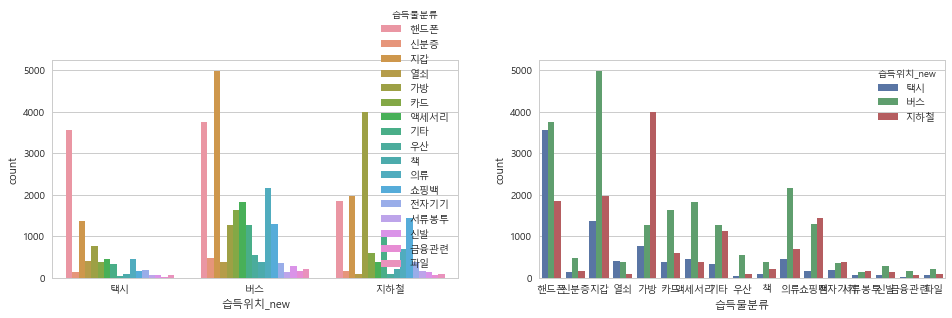

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=lost_data, x='습득위치_new',hue='습득물분류', ax=ax1)
sns.countplot(data=lost_data, x='습득물분류',hue='습득위치_new', ax=ax2)

### 분포 파악 결과

##### 1) Target 값인 '분실물상태'와 관련성이 매우 높은 변수의 처리 문제
* '수령가능장소_new' 변수는 변수 내 구분이 '분실물상태' 내 구분과 관련성이 높은 변수
* '보관'과는 달리 '경찰서이관'과 '우체국이관'의 경우 각 교통수단 별 분실센터에서 '수령가능'한 것으로 나타남
* 그러나 '보관'으로 분류된 데이터가 전체의 약 80%를 차지하고 있는 상황에서, '수령가능장소_new'는 향후 분석 결과에 매우 높은 영향을 줄 것으로 판단됨
* 따라서, 분석 시 '수령가능장소_new' 변수는 사용하지 않는 것이 바람직할 것임

#### 2) '습득위치_new' 변수 중 '지하철'='보관' 이라는 문제
* '택시'와 '버스'와는 달리 '지하철'에서 습득된 분실물은 모두 '보관'으로 분류됨
* 이와 같은 분포는 분석 결과에 과적합의 위험성을 내포한다고 판단됨
* 그러나 분실물의 습득위치에 따라 분실물 종류가 차이가 있다고 나타났기 때문에, 분석 시 '습득위치_new' 변수는 사용을 해야할 것으로 판단됨

### 데이터 전처리 with python

#### 1) 분석을 위한 변수 더미화

In [18]:
def dummification(x):
    if pd.isnull(x):
        return 0
    return 1

lost_data['Identifiable'] = lost_data['신원확인여부'].apply(dummification)
lost_data['Contected'] = lost_data['소유자연락여부'].apply(dummification)
lost_data['HasIMG'] = lost_data['이미지 URL'].apply(dummification)
lost_data['HasDESC'] = lost_data['습득물품_상세'].apply(dummification)

lost_data.tail()

,습득물품명,신원확인여부,소유자연락여부,습득일자,수령가능장소_new,수령가능장소연락처,습득물분류,습득위치_new,습득물품_상세,분실물상태,이미지 URL,Identifiable,Contected,HasIMG,HasDESC
43039,스카이.흰색,NaN,NaN,2007-12-17,우체국,02-577-5231,핸드폰,택시,NaN,우체국이관,NaN,0,0,0,0
43040,지갑(윤경식씨),1.0,NaN,2007-12-05,버스회사_분실센터,02-756-0670,지갑,버스,NaN,보관,NaN,1,0,0,0
43041,"가죽가방,통장(강문형)",1.0,NaN,2007-12-02,버스회사_분실센터,02-2662-2859,가방,버스,NaN,우체국이관,NaN,1,0,0,0
43042,010-2085-****,1.0,NaN,2007-11-03,택시회사_분실센터,011-324-4044,핸드폰,택시,NaN,보관,NaN,1,0,0,0
43043,지갑(박지현),1.0,NaN,2007-11-02,우체국,02-2662-2859,지갑,버스,NaN,우체국이관,NaN,1,0,0,0


#### 2) 더미화한 변수 제거

In [19]:
lost_data = lost_data.drop(['신원확인여부', '소유자연락여부', '습득물품_상세', '이미지 URL'], axis=1)
lost_data.tail()

,습득물품명,습득일자,수령가능장소_new,수령가능장소연락처,습득물분류,습득위치_new,분실물상태,Identifiable,Contected,HasIMG,HasDESC
43039,스카이.흰색,2007-12-17,우체국,02-577-5231,핸드폰,택시,우체국이관,0,0,0,0
43040,지갑(윤경식씨),2007-12-05,버스회사_분실센터,02-756-0670,지갑,버스,보관,1,0,0,0
43041,"가죽가방,통장(강문형)",2007-12-02,버스회사_분실센터,02-2662-2859,가방,버스,우체국이관,1,0,0,0
43042,010-2085-****,2007-11-03,택시회사_분실센터,011-324-4044,핸드폰,택시,보관,1,0,0,0
43043,지갑(박지현),2007-11-02,우체국,02-2662-2859,지갑,버스,우체국이관,1,0,0,0


In [20]:
lost_data.shape

(43044, 11)

#### 3) 습득일자 변수 정리 - 연/월/일 구분 후 습득일자 변수 제거

In [21]:
datetime = lost_data['습득일자'].str.split('-', expand=True)
lost_data['Year'] = datetime[0]
lost_data['Month'] = datetime[1]
lost_data['Date'] = datetime[2]

In [22]:
lost_data = lost_data.drop(['습득일자'], axis=1)
lost_data.tail()

,습득물품명,수령가능장소_new,수령가능장소연락처,습득물분류,습득위치_new,분실물상태,Identifiable,Contected,HasIMG,HasDESC,Year,Month,Date
43039,스카이.흰색,우체국,02-577-5231,핸드폰,택시,우체국이관,0,0,0,0,2007,12,17
43040,지갑(윤경식씨),버스회사_분실센터,02-756-0670,지갑,버스,보관,1,0,0,0,2007,12,05
43041,"가죽가방,통장(강문형)",버스회사_분실센터,02-2662-2859,가방,버스,우체국이관,1,0,0,0,2007,12,02
43042,010-2085-****,택시회사_분실센터,011-324-4044,핸드폰,택시,보관,1,0,0,0,2007,11,03
43043,지갑(박지현),우체국,02-2662-2859,지갑,버스,우체국이관,1,0,0,0,2007,11,02


#### 4) 텍스트로 이루어진 변수를 숫자로 인코딩

In [23]:
enc = LabelEncoder()
lost_data['Item'] = enc.fit_transform(lost_data['습득물분류'])
lost_data['Place_Item_founded'] = enc.fit_transform(lost_data['습득위치_new'])
lost_data['Item_condition'] = enc.fit_transform(lost_data['분실물상태'])

lost_data.tail()

,습득물품명,수령가능장소_new,수령가능장소연락처,습득물분류,습득위치_new,분실물상태,Identifiable,Contected,HasIMG,HasDESC,Year,Month,Date,Item,Place_Item_founded,Item_condition
43039,스카이.흰색,우체국,02-577-5231,핸드폰,택시,우체국이관,0,0,0,0,2007,12,17,16,2,2
43040,지갑(윤경식씨),버스회사_분실센터,02-756-0670,지갑,버스,보관,1,0,0,0,2007,12,05,12,0,1
43041,"가죽가방,통장(강문형)",버스회사_분실센터,02-2662-2859,가방,버스,우체국이관,1,0,0,0,2007,12,02,0,0,2
43042,010-2085-****,택시회사_분실센터,011-324-4044,핸드폰,택시,보관,1,0,0,0,2007,11,03,16,2,1
43043,지갑(박지현),우체국,02-2662-2859,지갑,버스,우체국이관,1,0,0,0,2007,11,02,12,0,2


#### 5) 인코딩을 완료한 변수 제거

In [24]:
lost_data = lost_data.drop(['습득물분류', '습득위치_new', '분실물상태'], axis=1)
lost_data.tail()

,습득물품명,수령가능장소_new,수령가능장소연락처,Identifiable,Contected,HasIMG,HasDESC,Year,Month,Date,Item,Place_Item_founded,Item_condition
43039,스카이.흰색,우체국,02-577-5231,0,0,0,0,2007,12,17,16,2,2
43040,지갑(윤경식씨),버스회사_분실센터,02-756-0670,1,0,0,0,2007,12,05,12,0,1
43041,"가죽가방,통장(강문형)",버스회사_분실센터,02-2662-2859,1,0,0,0,2007,12,02,0,0,2
43042,010-2085-****,택시회사_분실센터,011-324-4044,1,0,0,0,2007,11,03,16,2,1
43043,지갑(박지현),우체국,02-2662-2859,1,0,0,0,2007,11,02,12,0,2


#### 6) 분석이 불필요한 변수 제거

* '습득물품명' 의 경우 전처리를 통해 '습득물분류'로 충분히 반영이 되었으며, 소유자 확인 또는 소유자 연락 여부가 반영이 완료되었음
* '수령자가능장소연락처' 의 경우 버스 / 택시 / 지하철 마다 연락처가 상이하고, 800여개의 데이터만 제외하고는 모두 연락처가 있기 때문에 분석에서 제외
* '수령가능장소_new'는 '분실물상태'와 연관성이 높아 과적합 방지를 위해 제외
* '연도'와 '일'의 경우 단순 숫자로서의 역할만 할 수 있기 때문에 'Year'과 'Date' 제외

In [25]:
lost_data = lost_data.drop(['습득물품명', '수령가능장소연락처', '수령가능장소_new', 'Year', 'Date'], axis=1)
lost_data.tail()

,Identifiable,Contected,HasIMG,HasDESC,Month,Item,Place_Item_founded,Item_condition
43039,0,0,0,0,12,16,2,2
43040,1,0,0,0,12,12,0,1
43041,1,0,0,0,12,0,0,2
43042,1,0,0,0,11,16,2,1
43043,1,0,0,0,11,12,0,2


### 분석과 테스트를 위한 Train & Test Data split

In [27]:
idx = np.random.rand(len(lost_data)) < 0.75

df_train = lost_data[idx]
df_test = lost_data[~idx]

print(len(df_test), len(df_train))

10904 32140


In [28]:
df_test.to_csv("test.csv", index=False)
df_train.to_csv("train.csv", index=False)

* Train data check

In [29]:
train = pd.read_csv("train.csv", encoding="EUC-KR")
train.tail()

,Identifiable,Contected,HasIMG,HasDESC,Month,Item,Place_Item_founded,Item_condition
32135,0,0,0,0,1,7,0,1
32136,0,0,0,0,12,2,2,1
32137,0,0,0,0,12,16,2,2
32138,1,0,0,0,12,0,0,2
32139,1,0,0,0,11,16,2,1


* Train data의 Y값 추출

In [30]:
train_Y = train['Item_condition']
train_Y.tail()

32135    1
32136    1
32137    2
32138    2
32139    1
Name: Item_condition, dtype: int64

In [31]:
train_X = train.drop(['Item_condition'], axis=1)
train_X.tail()

,Identifiable,Contected,HasIMG,HasDESC,Month,Item,Place_Item_founded
32135,0,0,0,0,1,7,0
32136,0,0,0,0,12,2,2
32137,0,0,0,0,12,16,2
32138,1,0,0,0,12,0,0
32139,1,0,0,0,11,16,2


* Test data check

In [32]:
test = pd.read_csv("test.csv", encoding="EUC-KR")
test.tail()

,Identifiable,Contected,HasIMG,HasDESC,Month,Item,Place_Item_founded,Item_condition
10899,0,0,0,0,3,16,0,0
10900,0,0,0,0,2,7,0,0
10901,0,0,0,0,1,16,0,1
10902,1,0,0,0,12,12,0,1
10903,1,0,0,0,11,12,0,2


* Test data의 Y 값 추출 (향후 평가에 활용)

In [33]:
test_Y = test['Item_condition']
test_Y.tail()

10899    0
10900    0
10901    1
10902    1
10903    2
Name: Item_condition, dtype: int64

In [34]:
test_X = test.drop(['Item_condition'], axis=1)
test_X.tail()

,Identifiable,Contected,HasIMG,HasDESC,Month,Item,Place_Item_founded
10899,0,0,0,0,3,16,0
10900,0,0,0,0,2,7,0
10901,0,0,0,0,1,16,0
10902,1,0,0,0,12,12,0
10903,1,0,0,0,11,12,0


### 분석 : Modeling, Cross Validation & Prediction with RandomForest & XGBoost

In [35]:
# Cross Validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train_X.values, train_Y.values, test_size=0.3, random_state=0)

#### RandomForest Model

In [36]:
#Choose best parameters for randomforest
def best_params(train_X, train_Y):
    rfc = RandomForestClassifier()
    param_grid = {'n_estimators': [50, 200, 500], 'max_features': ['auto', 'sqrt', 'log2']}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(train_X, train_Y)
    return CV_rfc.best_params_

print(best_params(train_X.values, train_Y.values))

{'max_features': 'log2', 'n_estimators': 200}


In [37]:
# RandomForest Classifier 

rf = RandomForestClassifier(n_estimators=200, max_features='log2').fit(X_train, y_train)
print('Cross Validation for RandomForestClassifier')
print(rf.score(X_test, y_test))

rf_prediction = pd.DataFrame(rf.predict(test_X.values))
#rf_prediction = pd.DataFrame(rf.predict_proba(test_X.values))
#prediction.columns = ['보관', '경찰서이관', '우체국이관']
#prediction = pd.concat([prediction], axis=1)

rf_prediction.tail()

Cross Validation for RandomForestClassifier
0.779817465256


,0
10899,1
10900,1
10901,1
10902,0
10903,0


* RandomForest 모델에 따른 변수 별 중요도 확인
    - 'Item', 'HasIMG', 'Place_Item_founded' 등의 순으로 중요도가 나타남
    - 즉, 분실물의 종류, 온라인을 통해 분실물의 상태 확인 가능 여부, 습득 위치 등이 분실물 처리에 있어서 중요한 변수로 나타남

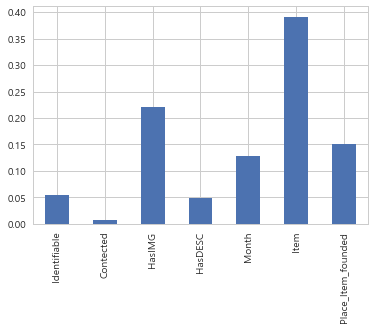

In [38]:
importances_rf = rf.feature_importances_
features_names = ['Identifiable', 'Contected', 'HasIMG', 'HasDESC', 'Month', 'Item', 'Place_Item_founded']
pd.Series(importances_rf, index=features_names).plot(kind='bar')

In [41]:
target_names = ['경찰서이관', '보관', '우체국이관']
print(classification_report(test_Y, rf_prediction, target_names=target_names))

             precision    recall  f1-score   support

      경찰서이관       0.46      0.20      0.28      1626
         보관       0.82      0.94      0.88      8340
      우체국이관       0.51      0.35      0.41       938

avg / total       0.74      0.78      0.75     10904



#### RandomForest Model, Cross Validation & Prediction 결과

* RandomForest 모델 학습 결과, 모델의 예측 정확도는 약 78.0%로 나타남
* 학습된 모델을 test set에 적용시킨 결과, precision : 약 74% / recall : 약 75% / F1-score : 약 75%로 나타남
* 모델에서 중요한 변수로는 '습득품분류', '이미지 URL', '습득위치' 등으로 나타남

#### XGBoost Model

In [42]:
# Simple XGBClassifier. 
xgboost = XGBClassifier(learning_rate =0.05, n_estimators=400, max_depth=5).fit(X_train, y_train)

print('Cross Validation for XGBClassifier')
print(xgboost.score(X_test, y_test))

xgb_prediction = pd.DataFrame(xgboost.predict(test_X.values))
#xgb_prediction = pd.DataFrame(xgboost.predict_proba(test_X.values))
#prediction.columns = ['보관', '경찰서이관', '우체국이관']
#prediction = pd.concat([prediction], axis=1)

xgb_prediction.tail()

Cross Validation for XGBClassifier
0.782202862477


,0
10899,1
10900,1
10901,1
10902,0
10903,0


* XGBoost 모델에 따른 변수 별 중요도 확인
    - 'Month', 'Item', 'Place_Item_founded' 등의 순으로 중요도가 나타남
    - 즉, 분실된 월, 분실물의 종류, 습득 위치 등이 분실물 처리에 있어서 중요한 변수로 나타남

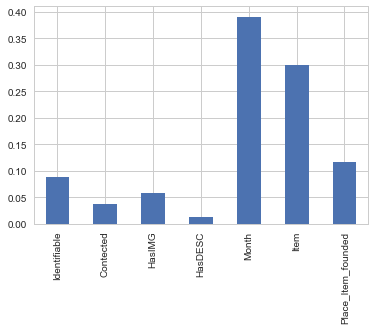

In [43]:
importances_xgb = xgboost.feature_importances_
pd.Series(importances_xgb, index=features_names).plot(kind='bar')

In [45]:
target_names = ['경찰서이관', '보관', '우체국이관']
print(classification_report(test_Y, xgb_prediction, target_names=target_names))

             precision    recall  f1-score   support

      경찰서이관       0.46      0.19      0.27      1626
         보관       0.82      0.95      0.88      8340
      우체국이관       0.53      0.34      0.41       938

avg / total       0.74      0.78      0.75     10904



#### XGBoost Model, Cross Validation & Prediction 결과

* XGBoost 모델 학습 결과, 모델의 예측 정확도는 약 78.2%로 나타남
* 학습된 모델을 test set에 적용시킨 결과, precision : 약 74% / recall : 약 78% / F1-score : 약 75%로 나타남
* 모델에서 중요한 변수로는 '습득시기 - 월', '습득물분류', '습득위치' 등으로 나타남

### 분석 결과 종합

#### 1. 두 모델의 예측 정확도를 측정하기 위한 점수는 각각 비슷한 수준으로 나타남
- Cross Validation score : 0.78
- Precision, Recall, F1-score : 각각 0.74, 0.78, 0.75

#### 2. 모델 별로 중요한 변수에는 차이가 있음
* 공통적으로 중요한 변수는 분실물의 종류, 분실물의 습득 위치
* 모델 별로 가장 중요한 변수는 다름
    - RandomForest : 분실물의 종류
    - XGBoost : 분실물이 접수/습득된 월
* 모델 별 변수의 중요도의 차이는 모델의 알고리즘의 차이에 기인한 것이나, 결론적으로 두 모델의 예측력에는 차이가 거의 없음

#### 3. 분석결과 해석
* RandomForest 모델의 중요한 변수 : 분실물의 종류, 분실물의 사진 링크 유무, 분실물의 습득 위치 등의 순
* XGBoost 모델의 중요한 변수 : 분실물 접수/습득된 월, 분실물의 종류, 분실물의 습득 위치 등의 순
* 즉, 두 모델의 차이는 변수의 중요도에 따른 차이
    - 분실물의 종류나 습득 위치의 경우, 분실물이 구분하고 처리하는데 있어서 중요할 수 있다고 판단됨 : 공통으로 중요한 변수
    - 분실물이 발생한 월의 경우 분실물의 계절성, 즉 특정 월에 어떤 분실물이 많이 발생하는지, 또는 어떤 교통수단에서 어떤 월에 분실물이 많이 나타나는지 등을 파악할 수 있는 변수이기는 하나, 분실물 처리 방향 자체를 나타내지는 않음
    - 분실물의 사진 링크 유무의 경우, 소유자가 본인의 분실물을 확인할 수 있는 방법중의 하나임
* 변수의 중요도를 고려하였을 때, RandomForest 모델이 XGBoost 모델보다 합리적인 예측모델로 판단할 수 있음

### 한계점

#### 1. 현재 운영되고 있는 대중교통 분실물 처리 프로세스가 반영되지 않은 데이터 → 실제 분실물 처리 과정과 상이할 가능성
* 현재 우리나라에서 운영되고 있는 대중교통 분실물 처리 프로세스는 다음과 같음
    - 최초 분실물의 습득/신고 접수가 발생하면, 해당 대중교통 업체에서 분실물을 보관하며 개별 홈페이지에 게시함
    - 접수 시점에서 2주 내에 주인이 회수 또는 우편으로 주인에게 발송하지 못할 경우, 경찰청 유실물센터로 이관
    - 경찰청 유실물센터(https://www.lost112.go.kr/)에 분실물을 게시하고, 6개월 내 주인이 찾아가지 않는 경우, 국고 귀속 / 공매물 경매 등으로 처리
* [서울 열린 데이터 광장]에서 확인할 수 있는 데이터는 이러한 프로세스가 반영되어 있지 않음
* 또한 경찰청 유실물센터의 게시 내용과의 연계가 이루어지지 않아, 각각의 분실물이 어떻게 처리가 되었는지가 확인되지 않음
* 즉, 분실물의 처리 결과가 명확하게 반영이 되어있지 않은 데이터임

#### 2. 분실물 처리 결과가 '보관'에 편중되어 있는 데이터 → 경찰청 유실물센터 데이터와의 연계가 필요함
* 1번에 따른 문제점으로 인해 데이터의 분실물 처리 결과가 '보관'이 약 80%로 편중되어 있음
* 이러한 문제를 해결하기 위해서는 bootstrap 기법 등을 이용해 upsampling / downsampling의 시도가 필요할 수 있으나, 본 분석에서는 실시하지 않음
* 현재 관리되고 있는 데이터 자체로서의 분석을 목적으로 하였기 때문이며, 위와 같은 데이터 관리의 연계성이 부족하기 때문
* [서울 열린 데이터 광장]에서 조회되는 원본 데이터와 [경찰청 유실물센터]의 데이터의 연계가 필요함

#### 3. 데이터 입력 상태 부실로 인한 전처리 과정의 비효율성 → 데이터 수집 및 입력 시 일관성이 필요함
* 데이터가 한글로 입력되어 있으며, 같은 종류의 분실물이어도 표기법이 각각 다르게 되어있음 (ex: 핸드폰 - 스마트폰, 폴더폰, 갤럭시, 휴대전화 등)
* 또한 분실물 분류와 분실물 내용이 일치하지 않는 데이터 또한 다수가 존재 (ex 분류 : 핸드폰 but 내용 : 노트북)
* 위와 같은 내용을 수정하기 위해서 모든 데이터를 확인할 필요가 있었음 - 매우 비효율적임
* 향후 이러한 데이터를 수집, 정리하고 공공의 데이터로 다양하게 활용하기 위해서는 데이터를 입력할 때 부터 일정한 카테고리 범주로 지정하여 입력한다면 보다 효율적인 데이터 수집이 가능할 것으로 판단됨

#### 4. 분실물 데이터 분석 가능 항목(변수) 개수가 적음  → 분실물의 상태를 적극적으로 나타낼 수 있는 변수 필요
* 최초 데이터의 분석 가능한 변수의 개수는 ID를 제외하고 13개
    - 그러나 중복되는 변수가 있고, 실제 분석이 가능한 변수는 11개
    - 이 중 분석의 목표가 되는 변수를 제외하면 최종적으로 10개를 기반으로 분석해야 함
* 분실물의 다양한 상태를 반영할 수 있는 추가적인 데이터가 필요함 (ex : 분실물 소유자 명, 분실물 색상, 분실물 브랜드, 분실물 습득 위치 등)
    - 분실물에 대한 상세 설명에서 이러한 내용이 있는 데이터도 있으나, 전반적으로 볼 때 부족함
    - 본 분석 시 이러한 상황을 극복하기 위해 소유자 명이나 연락처가 기입된 변수에 대해서 구분할 수 있는 변수를 추가하였으나, 실제 이러한 변수의 중요도는 낮은 것으로 나타남
    - 분실물의 상태를 나타내는 다양한 변수가 추가된다면 보다 효율적인 분실물 관리 및 예측이 가능할 것으로 판단됨